<h2>INSTALLAZIONE LIBRERIE</h2>

<p style="font-size:14px; font-family:verdana; line-height: 1.7em">
Installazione librerie <strong>necessarie per il funzionamento</strong> del progetto:
</p>

In [1]:
pip install --quiet --upgrade pip scipy matplotlib wordcloud seaborn nltk scikit-learn plotly nbformat imbalanced-learn tqdm xgboost pillow tabulate

Note: you may need to restart the kernel to use updated packages.


<h2>IMPORTAZIONE LIBRERIE</h2>

In [2]:
# Calcolo e manipolazione dati
import numpy as np
import pandas as pd
from collections import Counter
import re
import string
import warnings

# NLP e Preprocessing
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

# Gestione degli squilibri di classe
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

# Machine Learning e Modelli
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# Metriche di valutazione
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay, log_loss, precision_recall_fscore_support, classification_report, accuracy_score, f1_score, precision_score, recall_score)
from tabulate import tabulate

# Utility
from sklearn.utils import resample
from tqdm import tqdm  # Barra di avanzamento
import time
import matplotlib.image as mpimg
from IPython.display import Image, display
from IPython.core.display import HTML
from sklearn.exceptions import ConvergenceWarning

# Visualizzazione
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as py
py.init_notebook_mode(connected=True)

# Ignorare avvisi
warnings.filterwarnings('ignore')
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter("ignore", ConvergenceWarning)


In [3]:
def plot_class_distribution(df, column_name, title='Distribuzione delle Classi', color='navy', ax=None):
    # Impostazioni estetiche per il grafico
    sns.set(style="darkgrid")  # Aggiunge uno sfondo gradevole

    # Creazione del grafico
    if ax is None:
        ax = plt.gca()  # Se non viene passato un asse, usa quello corrente
    sns.countplot(x=column_name, data=df, color=color, ax=ax)  # Imposta un colore uniforme per le barre

    # Titolo e etichette
    ax.set_title(title, fontsize=16)
    ax.set_xlabel('Classi', fontsize=14)
    ax.set_ylabel('Numero di Occorrenze', fontsize=14)

    # Aggiungere il numero sopra ogni barra con lo stesso colore della barra
    for p in ax.patches:
        height = int(p.get_height())  # Otteniamo l'altezza della barra
        ax.annotate(f'{height}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', fontsize=12, 
                    color=p.get_facecolor(),  # Impostiamo il colore del testo uguale a quello della barra
                    xytext=(0, 5), textcoords='offset points')


<h2>ESPLORAZIONE DEI DATI (EDA)</h2>

In [4]:
# Caricamento Dataset
training_variants = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_variants.csv")
training_text = pd.read_csv("/Users/diego/Desktop/TIROCINIO/DATASET/training_text.csv", sep="\|\|", engine='python', header=None, skiprows=1, names=['ID','text'])

# Stampa strutturata dei dati
print(f"{'\nDataset':<20}{'(Righe, Colonne)':<30}")
print(f"{'-'*50}")
print(f"{'Training variants':<20}{str(training_variants.shape):<30}")
print(f"{'Training text':<20}{str(training_text.shape):<30}")



Dataset            (Righe, Colonne)              
--------------------------------------------------
Training variants   (3321, 4)                     
Training text       (3321, 2)                     


In [5]:
#unione varianti e testo di addestramento 
df = pd.merge(training_variants, training_text, on = 'ID')
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,Cyclin-dependent kinases (CDKs) regulate a var...
1,1,CBL,W802*,2,Abstract Background Non-small cell lung canc...
2,2,CBL,Q249E,2,Abstract Background Non-small cell lung canc...
3,3,CBL,N454D,3,Recent evidence has demonstrated that acquired...
4,4,CBL,L399V,4,Oncogenic mutations in the monomeric Casitas B...


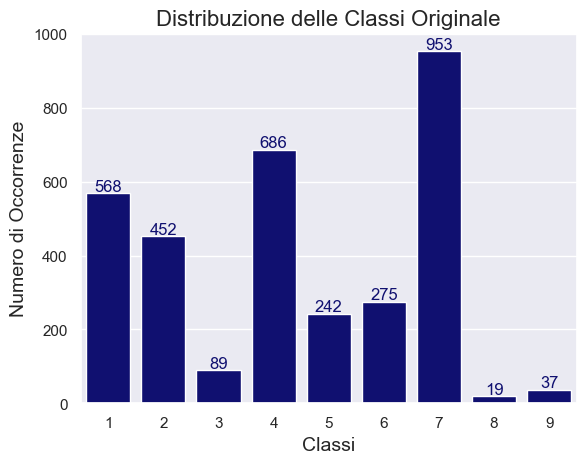

In [6]:
# Distribuzione delle Classi Originale
plot_class_distribution(df, column_name='Class', title='Distribuzione delle Classi Originale', color='navy')

<h2>PRE-PROCESSING DEI DATI</h2>

In [7]:
# Inserimento di altre stop words manualmente adatte al contesto
custom_words = ["fig", "figure", "et", "al", "al.", "also", "data", "analyze", "study", 
                "table", "using", "method", "result", "conclusion", "author", "find", "found", "show"]

# Unione delle stop words di default + la punteggiatura + quelle aggiunte manualmente 
stop_words = set(stopwords.words('english') + list(string.punctuation) + custom_words)

wordnet_lemmatizer = WordNetLemmatizer()

def pre_process(text):
    if isinstance(text, float):
        return ''  # Gestione di valori float
    
    text = str(text).lower().strip()
    
    # Rimozione di punteggiatura, HTML e caratteri speciali
    text = re.sub(f'[{re.escape(string.punctuation)}]', ' ', text)
    text = re.sub(r'<.*?>+', ' ', text)
    text = re.sub(r'[^a-zA-Z0-9\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    # Tokenizzazione, rimozione stopwords e lemmatizzazione
    tokens = word_tokenize(text)
    filtered_tokens = [
        wordnet_lemmatizer.lemmatize(word) for word in tokens 
        if word not in stop_words and not word.isdigit() and len(word) > 1  # ignora parole di lunghezza 1
    ]
    
    return ' '.join(filtered_tokens)



def process_corpus(df, text_column, class_column):
    return df.groupby(class_column).apply(lambda x: Counter(word_tokenize(pre_process(x[text_column].str.cat(sep=' ')))))


In [8]:
# Preprocessing dei dati con barra di avanzamento
print("Preprocessing dei dati...")
df['text'] = [pre_process(text) for text in tqdm(df['text'], desc="Preprocessing")]

Preprocessing dei dati...


Preprocessing: 100%|████████████████████████| 3321/3321 [01:36<00:00, 34.51it/s]


In [9]:
df.head()

,ID,Gene,Variation,Class,text
0,0,FAM58A,Truncating Mutations,1,cyclin dependent kinase cdks regulate variety ...
1,1,CBL,W802*,2,abstract background non small cell lung cancer...
2,2,CBL,Q249E,2,abstract background non small cell lung cancer...
3,3,CBL,N454D,3,recent evidence demonstrated acquired uniparen...
4,4,CBL,L399V,4,oncogenic mutation monomeric casitas lineage l...


In [10]:
# Cerchiamo righe con valori nulli o con la colonna 'text' vuota
df[df.isnull().any(axis=1) | (df['text'] == '')]

num_righe_mancanti = df[df.isnull().any(axis=1) | (df.select_dtypes(include=['object']).eq('').any(axis=1))].shape[0]
print(f"Numero di righe con feature mancanti o vuote: {num_righe_mancanti}")


Numero di righe con feature mancanti o vuote: 5


In [11]:
# Elimina righe con valori nulli o con campo 'text' vuoto
df = df.dropna(subset=["text"]).loc[df['text'] != '']

num_righe_mancanti = df[df.isnull().any(axis=1) | (df.select_dtypes(include=['object']).eq('').any(axis=1))].shape[0]
print(f"Numero di righe con feature mancanti o vuote dopo Eliminazione: {num_righe_mancanti}")


Numero di righe con feature mancanti o vuote dopo Eliminazione: 0


In [24]:
df.to_csv(r'/Users/diego/Desktop/dataset_ottimizzato.csv', index=False)

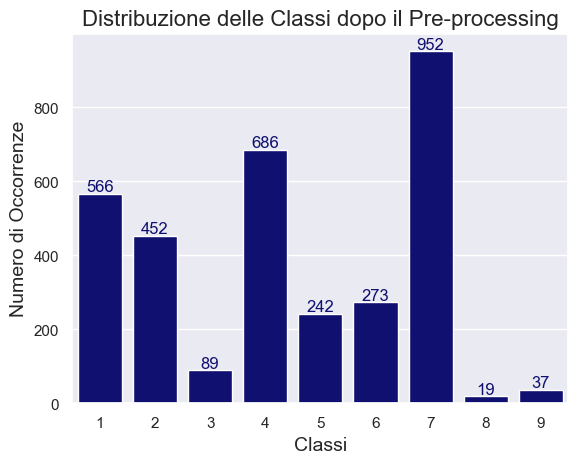

In [12]:
# Distribuzione delle Classi dopo il Pre-processing
plot_class_distribution(df, column_name='Class', title='Distribuzione delle Classi dopo il Pre-processing', color='navy')


In [13]:
df['Class'].value_counts()

Class
7    952
4    686
1    566
2    452
6    273
5    242
3     89
9     37
8     19
Name: count, dtype: int64

<h3> PRE-PROCESSING DEI DATI</h3>

In [14]:
# Separazione delle feature e della target
X_text = df['text']
X_gene_variation = df[['Gene', 'Variation']]
y = df['Class']

In [15]:
# Encoding per Gene e Variation
X_gene_variation_encoded = pd.get_dummies(X_gene_variation, columns=['Gene', 'Variation'])

# Vettorizzazione del testo
tfidf = TfidfVectorizer(max_features=10000)
X_text_vectorized = tfidf.fit_transform(X_text).toarray()

# Applicazione di SVD per la riduzione della dimensionalità
svd = TruncatedSVD(n_components=100)  
X_text_svd = svd.fit_transform(X_text_vectorized)

# Unione delle feature
X = np.hstack([X_text_svd, X_gene_variation_encoded.values])

print(f"Dimensioni delle feature Gene e Variation codificate: {X_gene_variation_encoded.shape}")
print(f"Dimensioni del Testo Vettorializzato: {X_text_svd.shape}")

# Stampa delle dimensioni del dataset finale
print(f"Dimensioni del dataset finale: {X.shape}")

Dimensioni delle feature Gene e Variation codificate: (3316, 3255)
Dimensioni del Testo Vettorializzato: (3316, 100)
Dimensioni del dataset finale: (3316, 3355)


<h2> MODELLAZIONE</h2>

<h3> BILANCIAMENTI</h3>

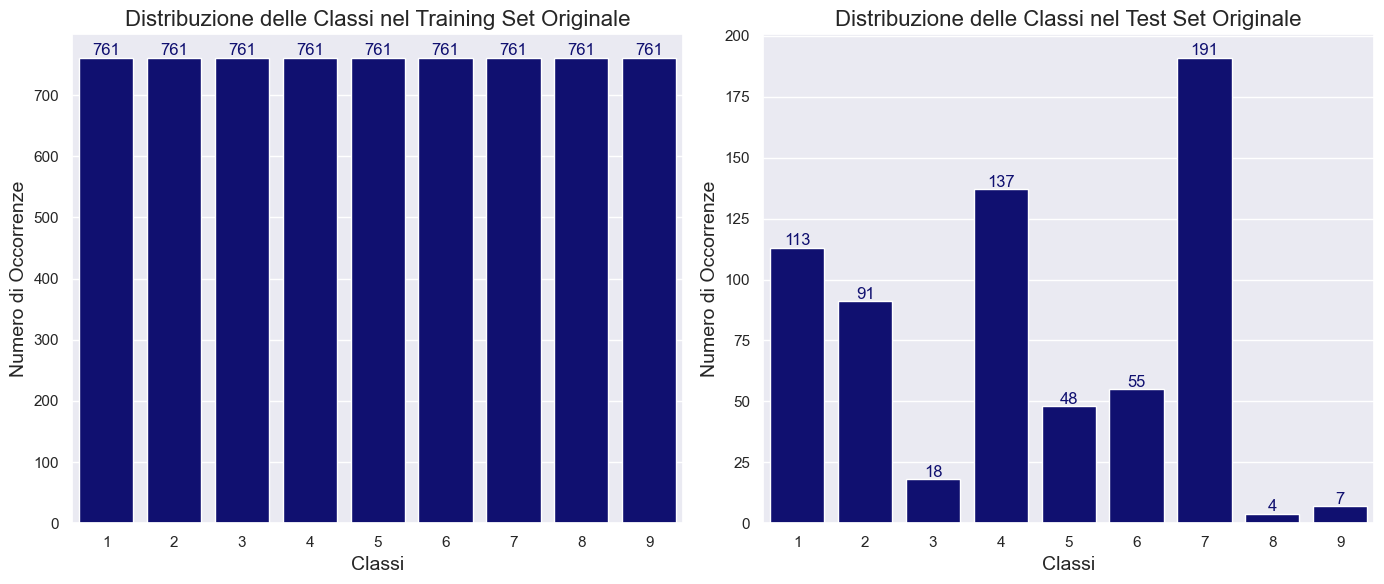

In [19]:
# Separazione in training e test (80-20) mantenendo la stessa distribuzione delle classi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Applicazione del RandomOverSampler per aumentare la classe minoritaria
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_over, y_train_over = oversampler.fit_resample(X_train, y_train)

# Visualizza la distribuzione delle classi nel training e nel test set
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Grafico per il training set
plot_class_distribution(df=pd.DataFrame({'Class': y_train_over}), column_name='Class', title='Distribuzione delle Classi nel Training Set Originale', color='navy', ax=axes[0])

# Grafico per il test set
plot_class_distribution(df=pd.DataFrame({'Class': y_test}), column_name='Class', title='Distribuzione delle Classi nel Test Set Originale', color='navy', ax=axes[1])

# Ottimizzazione della disposizione dell'intero layout
plt.tight_layout()
plt.show()

In [26]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report

# 1. Creazione del modello RandomForest con il parametro class_weight impostato su 'balanced'
rf = RandomForestClassifier(random_state=42, class_weight='balanced')

# 2. Definizione della griglia di iperparametri da ottimizzare
param_grid = {
    'n_estimators': [200],  # Numero di alberi
    'max_depth': [None, 10, 20, 30],  # Profondità massima degli alberi
}

# 3. Creazione della validazione incrociata con StratifiedKFold
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# 4. Ottimizzazione del modello tramite GridSearchCV con F1-score come metrica di valutazione
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=cv, n_jobs=-1, scoring='f1')
grid_search.fit(X_train_over, y_train_over)

# 5. Visualizzazione dei migliori iperparametri
print(f"Migliori parametri: {grid_search.best_params_}")

# 6. Creazione del modello finale con i migliori iperparametri
best_rf = grid_search.best_estimator_

# 7. Previsione sui dati di test
y_pred = best_rf.predict(X_test)

# 8. Valutazione del modello con le metriche di precisione, recall, f1-score e supporto
print("Report di classificazione:\n", classification_report(y_test, y_pred))


/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:982: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 971, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 279, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/opt/homebrew/Cellar/jupyterlab/4.2.5_1/libexec/lib/python3.12/site-packages/sklearn/metrics/_scorer.py", line 376, in _score
    return se

Migliori parametri: {'max_depth': None, 'n_estimators': 200}
Report di classificazione:
               precision    recall  f1-score   support

           1       0.58      0.59      0.59       113
           2       0.67      0.54      0.60        91
           3       0.33      0.44      0.38        18
           4       0.70      0.61      0.65       137
           5       0.39      0.46      0.42        48
           6       0.80      0.58      0.67        55
           7       0.70      0.83      0.76       191
           8       0.00      0.00      0.00         4
           9       0.75      0.86      0.80         7

    accuracy                           0.64       664
   macro avg       0.55      0.55      0.54       664
weighted avg       0.65      0.64      0.64       664

